In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Racine du projet (fonctionne depuis /notebooks ou depuis la racine)
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

DATA_RAW = ROOT / "data" / "raw"
FIG_DIR = ROOT / "reports" / "figures"
METRICS_DIR = ROOT / "reports" / "metrics"
MODELS_DIR = ROOT / "models"

FIG_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "SalePrice"
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print("ROOT:", ROOT)
print("train.csv exists:", (DATA_RAW / "train.csv").exists())


ROOT: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice
train.csv exists: True


In [3]:
path = "../data/raw/train.csv"
df_house = pd.read_csv(path)
display(df_house.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
TARGET = "SalePrice"
print("Target:", TARGET)
df_house.shape

Target: SalePrice


(1460, 81)

In [5]:
df_house[TARGET].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Interprétation 

médiane (50%) = 163 000 : c’est le “prix central” (la moitié des maisons est en dessous, l’autre moitié au-dessus).

Q1 (25%) = 129 975 : 25% des maisons coûtent et sont ≤ 129 975.

Q3 (75%) = 214 000 : 75% des maisons coûtent et sont ≤ 214 000.

La majorité des maisons est entre ~130k et ~214k

Moyenne vs médiane 

mean = 180 921

median = 163 000

La moyenne > la medianne signifie que la distribution asymétrique à droite  
Donc quelques maisons très chères tirent la moyenne vers le haut.

Dispersion

std = 79 442 :l'écart-type est assez élevé

Les prix sont très dispersés et la variabilité est importante.

Outliers / valeurs extrêmes

max = 755 000
Q3 = 214 000
Ratio max / Q3 = 755000 / 214000 ≈ 3.53
Le maximum est 3,5 fois le 3e quartile

La présence présence probable de valeurs extrêmes côté haut donc maisons très chères.

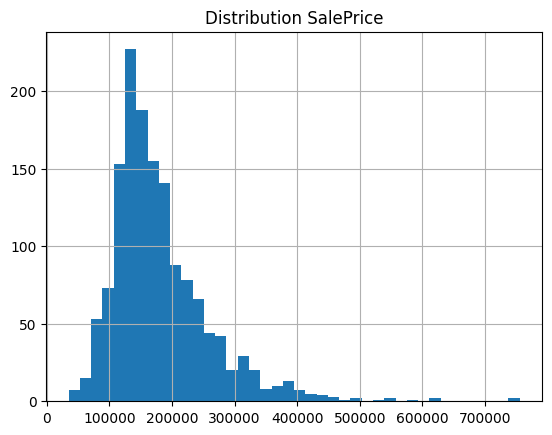

Skew: 1.8828757597682129


In [6]:
# Repreentation de l'histogramme + skew
plt.figure()
df_house[TARGET].hist(bins=40)
plt.title("Distribution SalePrice")
plt.savefig(FIG_DIR / "saleprice_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("Skew:", df_house[TARGET].skew())

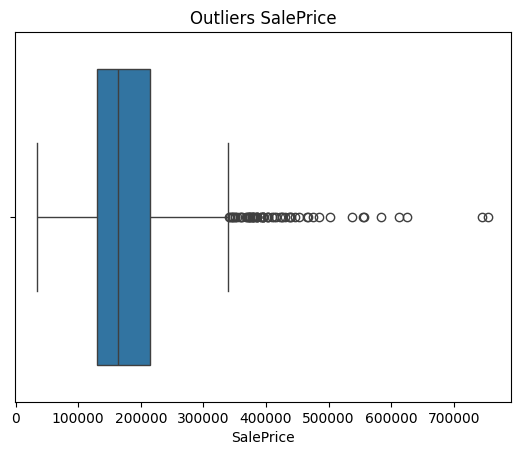

In [8]:
# Repreentation de l'histogramme boxplot outliers
plt.figure()
sns.boxplot(x=df_house[TARGET])
plt.title("Outliers SalePrice")
plt.savefig(FIG_DIR / "saleprice_outliers_boxplot.png", dpi=150, bbox_inches="tight")
plt.show()

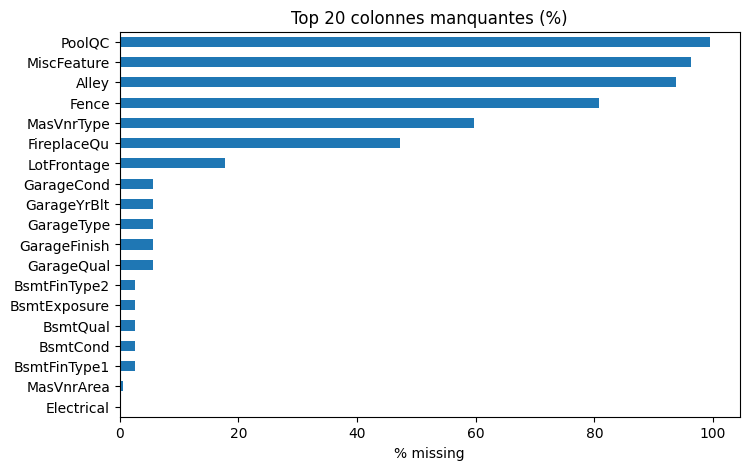

In [9]:
#Les manquants
missing_pct = df_house.isna().mean().sort_values(ascending=False) * 100
top_missing = missing_pct[missing_pct > 0].head(20)

plt.figure(figsize=(8,5))
top_missing.sort_values().plot(kind="barh")
plt.title("Top 20 colonnes manquantes (%)")
plt.xlabel("% missing")
plt.savefig(FIG_DIR / "missing_top20.png", dpi=150, bbox_inches="tight")
plt.show()

In [10]:
# La ccorrélation target
num_df = df_house.select_dtypes(include=["int64","float64"])
corr = num_df.corr(numeric_only=True)
corr[TARGET].abs().sort_values(ascending=False).head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

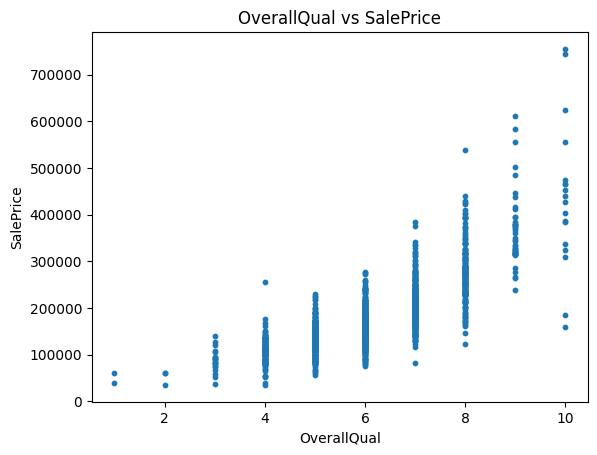

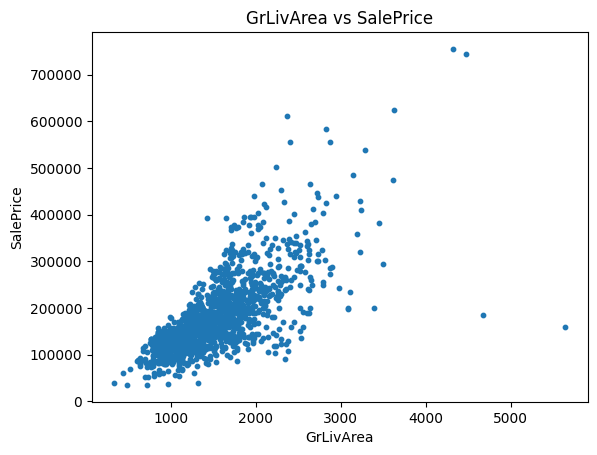

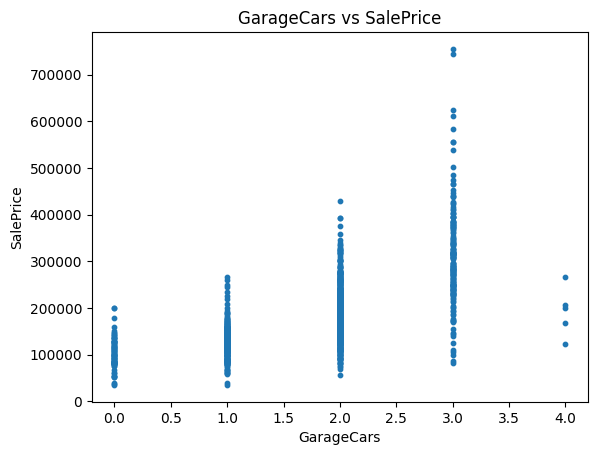

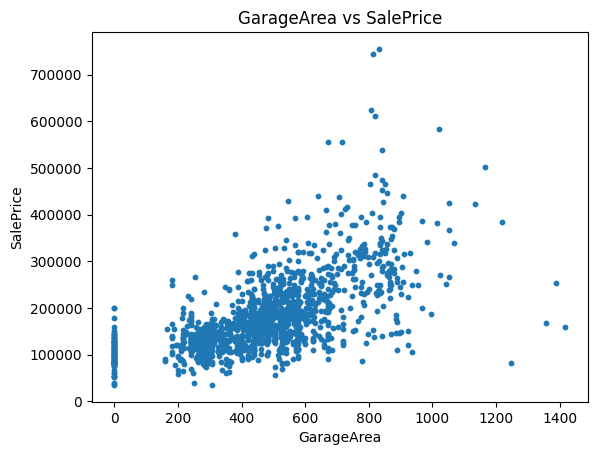

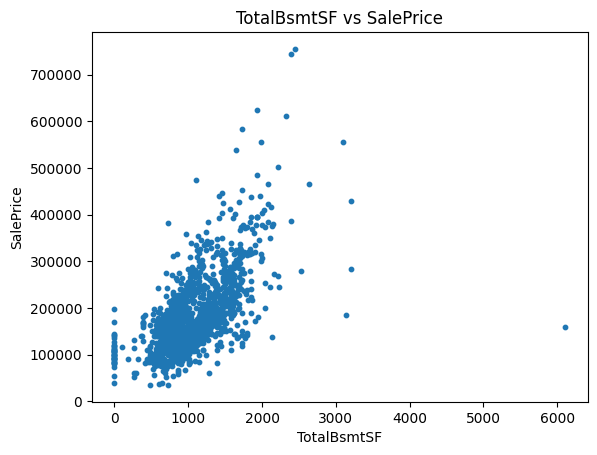

In [11]:
#scatter top 5 variables
top_features = corr[TARGET].abs().sort_values(ascending=False).index[1:6]

for col in top_features:
    plt.figure()
    plt.scatter(df_house[col], df_house[TARGET], s=10)
    plt.title(f"{col} vs {TARGET}")
    plt.xlabel(col)
    plt.ylabel(TARGET)
    plt.savefig(FIG_DIR / f"scatter_{col}.png", dpi=150, bbox_inches="tight")
    plt.show()

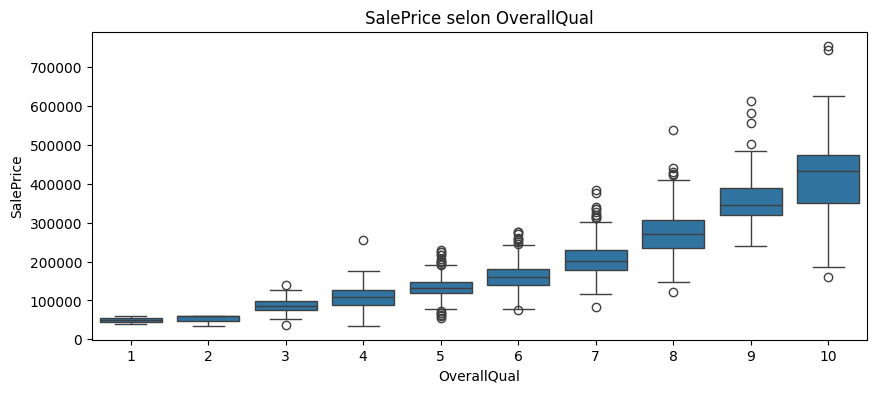

In [12]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_house, x="OverallQual", y=TARGET)
plt.title("SalePrice selon OverallQual")
plt.savefig(FIG_DIR / "saleprice_vs_overallqual.png", dpi=150, bbox_inches="tight")
plt.show()